In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime


## Котировки

In [4]:
df = pd.read_csv('Data/TQBR.SBER_D1.txt', sep='\t')

In [5]:
def func_1(x):
    
    return datetime.strptime(x[:10], '%d.%m.%Y')

df.datetime = df.datetime.apply(lambda x: func_1(x))
df.datetime = df.datetime.astype('datetime64')

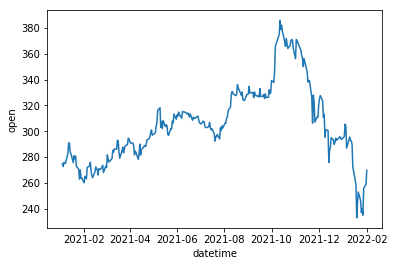

In [6]:
sns.lineplot(data=df.loc[lambda x: x.datetime >= pd.to_datetime('2021-01-01')], x="datetime", y="open")

In [7]:
df = df.loc[lambda x: x.datetime >= pd.to_datetime('2021-01-01')].set_index('datetime')
df.head()

,open,high,low,close,volume
datetime,,,,,
2021-01-04,274.67,276.60,270.61,272.00,4879946
2021-01-05,272.67,275.70,270.28,275.20,4555410
2021-01-06,275.90,275.92,271.62,272.93,4090534
2021-01-08,275.11,283.99,275.11,283.64,8867294
2021-01-11,282.75,292.95,279.48,289.49,11221040


## Индикатор

In [8]:
# RSI CALCULATION

def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

df = df.reset_index().merge(get_rsi(df['close'], 14).reset_index().rename(columns={'rsi':'rsi_14'}), on='datetime', how='left')\
       .set_index('datetime')

df = df.dropna()
df.tail()

,open,high,low,close,volume,rsi_14
datetime,,,,,,
2022-01-26,240.06,245.17,233.30,236.90,22480044,30.639999
2022-01-27,234.99,260.00,233.10,254.29,30118789,41.785815
2022-01-28,255.86,262.00,252.02,257.82,20415396,43.761406
2022-01-31,258.88,269.60,258.81,269.42,15608754,49.791368
2022-02-01,269.72,273.10,260.56,262.30,16328436,46.496011


## TRADING STRATEGY

In [9]:
def implement_rsi_strategy(prices, rsi):    
    buy_price = []
    sell_price = []
    rsi_signal = []
    signal = 0

    for i in range(len(rsi)):
        if rsi[i-1] > 30 and rsi[i] < 30:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        elif rsi[i-1] < 70 and rsi[i] > 70:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            rsi_signal.append(0)
            
    return buy_price, sell_price, rsi_signal
            

buy_price, sell_price, rsi_signal = implement_rsi_strategy(df['close'], df['rsi_14'])

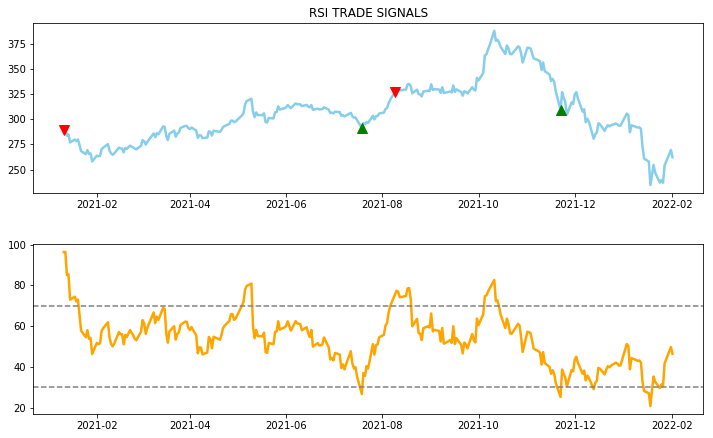

In [10]:
plt.figure(figsize=(12,8))  
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(df['close'], linewidth = 2.5, color = 'skyblue', label = 'IBM')
ax1.plot(df.index, buy_price, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
ax1.plot(df.index, sell_price, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
ax1.set_title('RSI TRADE SIGNALS')
ax2.plot(df['rsi_14'], color = 'orange', linewidth = 2.5)
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
plt.show()

## POSITION

In [17]:
# POSITION

position = []
for i in range(len(rsi_signal)):
    if rsi_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(df['close'])):
    if rsi_signal[i] == 1:
        position[i] = 1
    elif rsi_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
rsi = df['rsi_14']
close_price = df['close']
rsi_signal = pd.DataFrame(rsi_signal).rename(columns = {0:'rsi_signal'}).set_index(df.index)
position = pd.DataFrame(position).rename(columns = {0:'rsi_position'}).set_index(df.index)

frames = [close_price, rsi, rsi_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy.head()

,close,rsi_14,rsi_signal,rsi_position
datetime,,,,
2021-01-11,289.49,96.349805,-1,0
2021-01-12,289.99,96.386096,0,0
2021-01-13,283.78,85.073197,0,0
2021-01-14,284.79,85.373876,0,0
2021-01-15,276.90,73.002586,0,0


In [20]:
strategy.loc[lambda x: abs(x.rsi_signal)==1]

,close,rsi_14,rsi_signal,rsi_position
datetime,,,,
2021-01-11,289.49,96.349805,-1,0
2021-07-19,291.46,26.757174,1,1
2021-08-09,326.91,75.511104,-1,0
2021-11-22,309.15,25.243322,1,1


## BACKTEST

In [22]:
# BACKTESTING

ibm_ret = pd.DataFrame(np.diff(df['close'])).rename(columns = {0:'returns'})
rsi_strategy_ret = []

for i in range(len(ibm_ret)):
    returns = ibm_ret['returns'][i]*strategy['rsi_position'][i]
    rsi_strategy_ret.append(returns)
    
rsi_strategy_ret_df = pd.DataFrame(rsi_strategy_ret).rename(columns = {0:'rsi_returns'})
investment_value = 10000
number_of_stocks = investment_value/df['close'][-1]
rsi_investment_ret = []

for i in range(len(rsi_strategy_ret_df['rsi_returns'])):
    returns = number_of_stocks*rsi_strategy_ret_df['rsi_returns'][i]
    rsi_investment_ret.append(returns)

rsi_investment_ret_df = pd.DataFrame(rsi_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(rsi_investment_ret_df['investment_returns']), 2)
profit_percentage = (total_investment_ret/investment_value)*100
print('Profit gained from the RSI strategy by investing $100k in IBM : {}'.format(total_investment_ret))
print('Profit percentage of the RSI strategy : {}%'.format(profit_percentage))

Profit gained from the RSI strategy by investing $100k in IBM : 607.73
Profit percentage of the RSI strategy : 6.0773%


In [23]:
# сбер
strategy.rsi_signal.value_counts()

 0    258
 1      2
-1      2
Name: rsi_signal, dtype: int64